### Problem 3

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('framingham_train.csv')
test  = pd.read_csv('framingham_test.csv')

In [3]:
# Target and features
y_train = train['TenYearCHD'].astype(int)
y_test  = test['TenYearCHD'].astype(int)

feature_cols = [c for c in train.columns if c != 'TenYearCHD']
X_train = train[feature_cols]
X_test  = test[feature_cols]

### Part 1

In [4]:
logreg = smf.logit(formula = 'TenYearCHD ~ male + age + education + currentSmoker + cigsPerDay + BPMeds + prevalentStroke + prevalentHyp + diabetes + totChol + sysBP + diaBP + BMI + heartRate + glucose',
                       data = train).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.379592
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 2560
Model:                          Logit   Df Residuals:                     2542
Method:                           MLE   Df Model:                           17
Date:                Thu, 09 Oct 2025   Pseudo R-squ.:                  0.1147
Time:                        00:05:35   Log-Likelihood:                -971.75
converged:                       True   LL-Null:                       -1097.6
Covariance Type:            nonrobust   LLR p-value:                 9.215e-44
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 


### Most Important Factors:

The most significant risk factors (based on p-value < 0.05) are:
- **male** (p < 0.001)
- **age** (p < 0.001) 
- **cigsPerDay** (p = 0.018)
- **totChol** (p = 0.016)
- **sysBP** (p = 0.006)
- **glucose** (p = 0.001)

**Description:** For the **age** variable, the coefficient is 0.0592. This means that for each one-year increase in age, the log-odds of developing CHD increases by 0.0592. In terms of odds ratio: $ e^{0.0592} \approx 1.061 $, meaning each additional year of age increases the odds of CHD by about 6.1%, holding all other factors the same.

#### Model Evaluation - Confusion Matrix

In [5]:
p_test = logreg.predict(X_test)             

pbar = 150000 / (0.85 * 950000)             
y_pred = (p_test >= pbar).astype(int)  

# Confusion matrix and metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = accuracy_score(y_test, y_pred)
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0   # True Positive Rate 
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0   # False Positive Rate

print(f"Threshold p̄ = {pbar:.6f}")
print(f"Accuracy = {accuracy:.4f}")
print(f"TPR = {tpr:.4f}")
print(f"FPR = {fpr:.4f}")
print(f"Confusion matrix: TP={tp}, FP={fp}, TN={tn}, FN={fn}")

Threshold p̄ = 0.185759
Accuracy = 0.7341
TPR = 0.5671
FPR = 0.2366
Confusion matrix: TP=93, FP=221, TN=713, FN=71


**Explanation:**

- Accuracy (73.4%): The model makes correct decisions for about 73% of patients. This means it is right most of the time.

- True Positive Rate (56.7%): When people actually get heart disease, the model finds about 57% of them. This means it catches more than half of the true heart disease cases.

- False Positive Rate (23.7%): When people are healthy, the model wrongly says about 24% of them have high risk. This means about 1 in 4 healthy people get unnecessary medicine.

In [6]:
# assuming that the CHD outcomes in the test set are not affected by the treatment decision.
treat = (p_test >= pbar).astype(int)

C_chd = 950000.0 # lifetime cost if CHD occurs
c_med = 150000.0 # medication cost

# Naive: outcomes assumed unchanged by treatment
cost_naive = treat * c_med + y_test * C_chd
naive_mean = cost_naive.mean()
print(f"Naive expected cost per patient = ${naive_mean:,.2f}")

Naive expected cost per patient = $184,790.53


In [7]:
# Use adjusted CHD risk
risk_factor = 0.15

cost_adj = np.where(
    treat == 1,
    c_med + risk_factor * p_test * C_chd,
    p_test * C_chd
)
adj_mean = cost_adj.mean()
print(f"Treatment-adjusted expected cost per patient = ${adj_mean:,.2f}")

Treatment-adjusted expected cost per patient = $116,660.56


#### Comment: 
The adjusted cost (\$116,660) is more realistic and shows the medication strategy saves money compared to the naive approach (184,790)

In [8]:
# Baseline model: treat no one
y_pred_baseline = np.zeros(len(y_test))

# Confusion matrix and metrics
tn_base, fp_base, fn_base, tp_base = confusion_matrix(y_test, y_pred_baseline).ravel()
accuracy_base = accuracy_score(y_test, y_pred_baseline)
tpr_base = tp_base / (tp_base + fn_base) if (tp_base + fn_base) > 0 else 0.0
fpr_base = fp_base / (fp_base + tn_base) if (fp_base + tn_base) > 0 else 0.0

# Economic cost for baseline (no treatment for anyone)
cost_base = y_test * C_chd
base_mean = cost_base.mean()

print(f"Baseline Model (Treat No One):")
print(f"Accuracy = {accuracy_base:.4f}")
print(f"TPR = {tpr_base:.4f}")
print(f"FPR = {fpr_base:.4f}")
print(f"Expected cost per patient = ${base_mean:,.2f}")
print(f"Confusion matrix: TP={tp_base}, FP={fp_base}, TN={tn_base}, FN={fn_base}")

Baseline Model (Treat No One):
Accuracy = 0.8506
TPR = 0.0000
FPR = 0.0000
Expected cost per patient = $141,894.35
Confusion matrix: TP=0, FP=0, TN=934, FN=164


**Explanation:**

- Accuracy (85%): The baseline appears very accurate because most patients are negative; accuracy here equals the share of non-CHD cases: $934 / 1098 \approx 0.8506$

- This is the baseline so it never predicts positive, so TPR = 0 (it catches none of the true CHD cases) and FPR = 0 (it never false-flags healthy people). Therefore, TPR = 0 and FPR = 0

- Economic Cost: The baseline incurs substantial costs $\text{\$141,894}$ per patient because all CHD cases occur without any preventive treatment, leading to full $\text{\$950,000}$ costs for each of the 164 CHD patients.

In [9]:
example = {
    'male': [1],
    'age': [40],
    'education': ['Some high school'],
    'currentSmoker': [1],
    'cigsPerDay': [2],
    'BPMeds': [0],
    'prevalentStroke': [1],
    'prevalentHyp': [1],
    'diabetes': [0],
    'totChol': [180],
    'sysBP': [140],
    'diaBP': [100],
    'BMI': [28],
    'heartRate': [80],
    'glucose': [100]
}

x_ex = pd.DataFrame(example)
p_ex = logreg.predict(x_ex).iloc[0] 
print(f"Predicted risk = {p_ex:.4f} ({p_ex*100:.2f}%)")

# Compare with threshold
print(f"Treatment threshold = {pbar:.4f} ({pbar*100:.2f}%)")

if p_ex > pbar:
    print("RECOMMENDATION: Prescribe preventive medication")
else:
    print("RECOMMENDATION: Do not prescribe medication")

Predicted risk = 0.1989 (19.89%)
Treatment threshold = 0.1858 (18.58%)
RECOMMENDATION: Prescribe preventive medication


**Answer**
- The predicted probability that this patient will experience CHD in the next ten years is 0.1989 (19.89%).
- Base on the $\bar{p}$ threshold, the physician should prescribe the preventive medication for this patient.

### Part 2

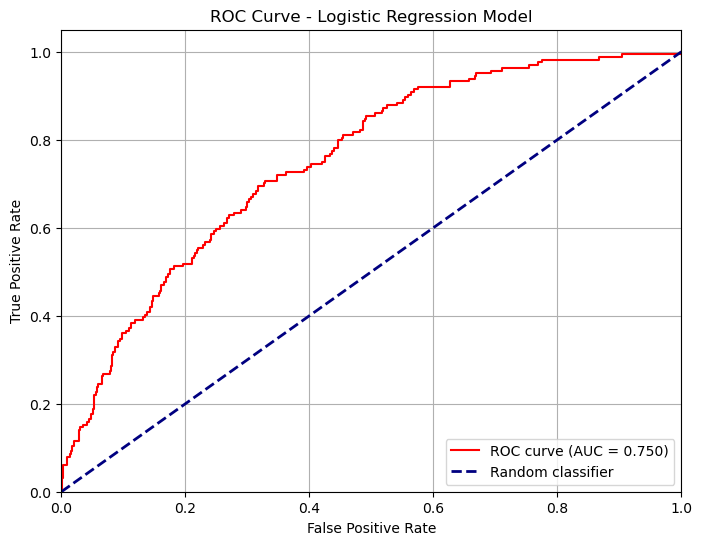

Area Under Curve (AUC) on test set: 0.7502

At treatment threshold p̄ = 0.1858:
True Positive Rate: 0.567
False Positive Rate: 0.232


In [10]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, p_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color = 'red',label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Area Under Curve (AUC) on test set: {roc_auc:.4f}")

# Find performance at optimal threshold (p̄)
threshold_idx = np.argmin(np.abs(thresholds - pbar))
tpr_at_pbar = tpr[threshold_idx]
fpr_at_pbar = fpr[threshold_idx]

print(f"\nAt treatment threshold p̄ = {pbar:.4f}:")
print(f"True Positive Rate: {tpr_at_pbar:.3f}")
print(f"False Positive Rate: {fpr_at_pbar:.3f}")

**Answer**
- The ROC curve shows how the model trades off between catching true CHD cases (TPR) and wrongly flagging healthy people (FPR) across many cutoffs. It helps decision-makers compare medicines with different costs and side effects: a cheap, safe drug may use a point with higher TPR; a costly drug with stronger side effects may use a point with lower FPR.
At the policy cutoff  $\bar p = 0.1858$, the model gives **TPR = 0.567** and **FPR = 0.232**.

- The curve rises quickly near the origin. This means the model can find many true cases while adding only a moderate number of false alarms at low risk levels. At $\bar p$, it finds about **57%** of true cases  of true cases while wrongly flagging about **23%** of healthy patients (about 1 in 4).

- Area Under the Curve (AUC = 0.7502). This shows the model has good ability to tell apart people who will get CHD from those who will not.